<a href="https://colab.research.google.com/github/timsetsfire/wandb-examples/blob/main/catboost_%2B_custom_eval_metric_%2B_sweeps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install wandb catboost -qqq

In [2]:
import wandb

In [3]:
import catboost
from catboost import *
import wandb
from wandb.catboost import WandbCallback
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
## generate data for logistic regression
X, g = make_circles(n_samples=(5000, 250), shuffle=True, noise=0.2, random_state=1, factor=0.35)
X_train, X_test, g_train, g_test = train_test_split(X, g, test_size = 0.3)
X_val, X_test, g_val, g_test = train_test_split(X_test, g_test, test_size = 0.1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


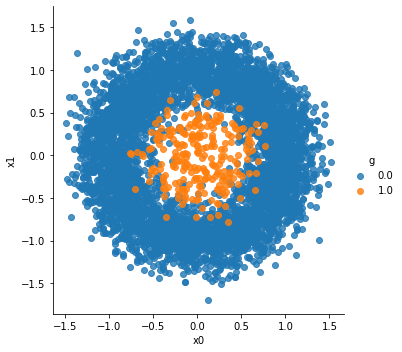

In [5]:
import seaborn as sns
import pandas as pd
Xm = np.matrix(X)
gm = np.matrix(g).T
data = pd.DataFrame( np.concatenate((Xm, gm),axis=1), columns = ["x0", "x1", "g"])
sns.lmplot('x0','x1',data = data,hue='g',fit_reg=False)

In [6]:
class ResponseAtTopNPercent(object):

    def __init__(self, p=0.1):
      self.p = p

    def get_final_error(self, error, weight):
      return error / weight

    def is_max_optimal(self):
      return True

    def evaluate(self, approxes, target, weight):
        preds = approxes[0]
        n = target.shape[0]
        m = int(self.p * n)
        sorted_probs_idx = np.argsort(-1 * preds)
        responses = target[sorted_probs_idx][0:m].sum()
        return responses, m

In [7]:
from google.colab import output

output.enable_custom_widget_manager()

In [8]:
import wandb

## Hyperparameter Search with W&B Sweeps

In [9]:
sweep_config = {
    'method': 'random',
    'name': 'cb-sweep',
    'metric': {'goal': 'maximize', 'name': 'validation-ResponseAtTopNPercent'},
    'parameters': 
    {
        'depth': {'values': [1, 3, 5, 10]}, 
        "l2_leaf_reg": {"max": 10, "min": 0}
     }, 
     
     "early_terminate": {
        "type": "hyperband",
        "min_iter": 3
      }
}

def train_func(): 
  with wandb.init() as run:


    model = CatBoostClassifier(eval_metric = ResponseAtTopNPercent(p = 0.10), **run.config)
    model = CatBoostClassifier(iterations = 10, loss_function = "Logloss", eval_metric = ResponseAtTopNPercent(p = 0.10))

    model.fit(
        X_train, g_train, plot=True, eval_set = [(X_val, g_val)], callbacks = [WandbCallback()]
        )
    from catboost import Pool
    eval_pool = Pool(data=X_val,
                    label=g_val,
                    )
    eval_metrics = model.eval_metrics(data=eval_pool, metrics=['Logloss', 'AUC', "F1", "Precision"])
    for key in eval_metrics:
      print( key, ":", eval_metrics[key][-1])
      run.log({key: eval_metrics[key][-1]})
  

In [10]:
sweep_id = wandb.sweep(sweep_config, project="catboost-test")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: q1ms21p4
Sweep URL: https://wandb.ai/tim-w/catboost-test/sweeps/q1ms21p4


In [ ]:
wandb_agent = wandb.agent(sweep_id, function=train_func, count = 5)

wandb: Agent Starting Run: ypveq7mh with config:
wandb: 	depth: 10
wandb: 	l2_leaf_reg: 2
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-w. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.8/dist-packages/catboost/core.py:2266: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.323987
0:	learn: 0.2261580	test: 0.1985816	best: 0.1985816 (0)	total: 314ms	remaining: 2.82s
1:	learn: 0.3460490	test: 0.3404255	best: 0.3404255 (1)	total: 317ms	remaining: 1.27s
2:	learn: 0.4277929	test: 0.4113475	best: 0.4113475 (2)	total: 321ms	remaining: 748ms
3:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 323ms	remaining: 484ms
4:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 325ms	remaining: 325ms
5:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 330ms	remaining: 220ms
6:	learn: 0.4495913	test: 0.4184397	best: 0.4184397 (6)	total: 334ms	remaining: 143ms
7:	learn: 0.4523161	test: 0.4255319	best: 0.4255319 (7)	total: 337ms	remaining: 84.1ms
8:	learn: 0.4468665	test: 0.4255319	best: 0.4255319 (7)	total: 339ms	remaining: 37.6ms
9:	learn: 0.4495913	test: 0.4184397	best: 0.4255319 (7)	total: 341ms	remaining: 0us

bestTest = 0.4255319149
bestIteration = 7

Shrink model to first 8 iterations.
Logloss : 0.10784784338282388


AUC,▁
F1,▁
Logloss,▁
Precision,▁
iteration@metric-period-1,▁▂▃▃▄▅▆▆▇█
learn-Logloss,█▆▄▃▂▂▂▁▁▁
learn-ResponseAtTopNPercent,▁▅▇███████
validation-Logloss,█▆▄▃▂▂▂▁▁▁
validation-ResponseAtTopNPercent,▁▅████████
AUC,0.96946
F1,0.62857


wandb: Agent Starting Run: r59zxgz4 with config:
wandb: 	depth: 3
wandb: 	l2_leaf_reg: 9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/local/lib/python3.8/dist-packages/catboost/core.py:2266: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.323987
0:	learn: 0.2261580	test: 0.1985816	best: 0.1985816 (0)	total: 137ms	remaining: 1.23s
1:	learn: 0.3460490	test: 0.3404255	best: 0.3404255 (1)	total: 149ms	remaining: 596ms
2:	learn: 0.4277929	test: 0.4113475	best: 0.4113475 (2)	total: 165ms	remaining: 384ms
3:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 167ms	remaining: 250ms
4:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 169ms	remaining: 169ms
5:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 175ms	remaining: 117ms
6:	learn: 0.4495913	test: 0.4184397	best: 0.4184397 (6)	total: 188ms	remaining: 80.4ms
7:	learn: 0.4523161	test: 0.4255319	best: 0.4255319 (7)	total: 198ms	remaining: 49.6ms
8:	learn: 0.4468665	test: 0.4255319	best: 0.4255319 (7)	total: 200ms	remaining: 22.3ms
9:	learn: 0.4495913	test: 0.4184397	best: 0.4255319 (7)	total: 206ms	remaining: 0us

bestTest = 0.4255319149
bestIteration = 7

Shrink model to first 8 iterations.
Logloss : 0.10784784338282388

AUC,▁
F1,▁
Logloss,▁
Precision,▁
iteration@metric-period-1,▁▂▃▃▄▅▆▆▇█
learn-Logloss,█▆▄▃▂▂▂▁▁▁
learn-ResponseAtTopNPercent,▁▅▇███████
validation-Logloss,█▆▄▃▂▂▂▁▁▁
validation-ResponseAtTopNPercent,▁▅████████
AUC,0.96946
F1,0.62857


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 78unuvqy with config:
wandb: 	depth: 5
wandb: 	l2_leaf_reg: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/local/lib/python3.8/dist-packages/catboost/core.py:2266: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.323987
0:	learn: 0.2261580	test: 0.1985816	best: 0.1985816 (0)	total: 56.2ms	remaining: 506ms
1:	learn: 0.3460490	test: 0.3404255	best: 0.3404255 (1)	total: 58.2ms	remaining: 233ms
2:	learn: 0.4277929	test: 0.4113475	best: 0.4113475 (2)	total: 59.9ms	remaining: 140ms
3:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 61.8ms	remaining: 92.6ms
4:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 63.5ms	remaining: 63.5ms
5:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 65.3ms	remaining: 43.5ms
6:	learn: 0.4495913	test: 0.4184397	best: 0.4184397 (6)	total: 67ms	remaining: 28.7ms
7:	learn: 0.4523161	test: 0.4255319	best: 0.4255319 (7)	total: 68.8ms	remaining: 17.2ms
8:	learn: 0.4468665	test: 0.4255319	best: 0.4255319 (7)	total: 70.7ms	remaining: 7.86ms
9:	learn: 0.4495913	test: 0.4184397	best: 0.4255319 (7)	total: 72.6ms	remaining: 0us

bestTest = 0.4255319149
bestIteration = 7

Shrink model to first 8 iterations.
Logloss : 0.107847

AUC,▁
F1,▁
Logloss,▁
Precision,▁
iteration@metric-period-1,▁▂▃▃▄▅▆▆▇█
learn-Logloss,█▆▄▃▂▂▂▁▁▁
learn-ResponseAtTopNPercent,▁▅▇███████
validation-Logloss,█▆▄▃▂▂▂▁▁▁
validation-ResponseAtTopNPercent,▁▅████████
AUC,0.96946
F1,0.62857


wandb: Agent Starting Run: ofqnkmn7 with config:
wandb: 	depth: 10
wandb: 	l2_leaf_reg: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/local/lib/python3.8/dist-packages/catboost/core.py:2266: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.323987
0:	learn: 0.2261580	test: 0.1985816	best: 0.1985816 (0)	total: 53.1ms	remaining: 478ms
1:	learn: 0.3460490	test: 0.3404255	best: 0.3404255 (1)	total: 57ms	remaining: 228ms
2:	learn: 0.4277929	test: 0.4113475	best: 0.4113475 (2)	total: 61.5ms	remaining: 144ms
3:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 64.3ms	remaining: 96.5ms
4:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 66.3ms	remaining: 66.3ms
5:	learn: 0.4495913	test: 0.4113475	best: 0.4113475 (2)	total: 67.9ms	remaining: 45.3ms
6:	learn: 0.4495913	test: 0.4184397	best: 0.4184397 (6)	total: 69.8ms	remaining: 29.9ms
7:	learn: 0.4523161	test: 0.4255319	best: 0.4255319 (7)	total: 71.6ms	remaining: 17.9ms
8:	learn: 0.4468665	test: 0.4255319	best: 0.4255319 (7)	total: 73.2ms	remaining: 8.13ms
9:	learn: 0.4495913	test: 0.4184397	best: 0.4255319 (7)	total: 74.7ms	remaining: 0us

bestTest = 0.4255319149
bestIteration = 7

Shrink model to first 8 iterations.
Logloss : 0.107847

AUC,▁
F1,▁
Logloss,▁
Precision,▁
iteration@metric-period-1,▁▂▃▃▄▅▆▆▇█
learn-Logloss,█▆▄▃▂▂▂▁▁▁
learn-ResponseAtTopNPercent,▁▅▇███████
validation-Logloss,█▆▄▃▂▂▂▁▁▁
validation-ResponseAtTopNPercent,▁▅████████
AUC,0.96946
F1,0.62857
